IMPORTS

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns # visualizing data with stunning default theme
import sklearn # contain algorithms
import warnings
warnings.filterwarnings('ignore')

# load dataset from input directory
df = pd.read_csv("datasets\common_voice\cv-valid-train.csv") 
df[df['age'].notna()].head()

,filename,text,age,gender
0,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,twenties,female
1,cv-valid-train/sample-000008.mp3,put jackie right on the staff,seventies,male
2,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,thirties,female
3,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,sixties,male
4,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,fifties,male


DATA EXPLORATION

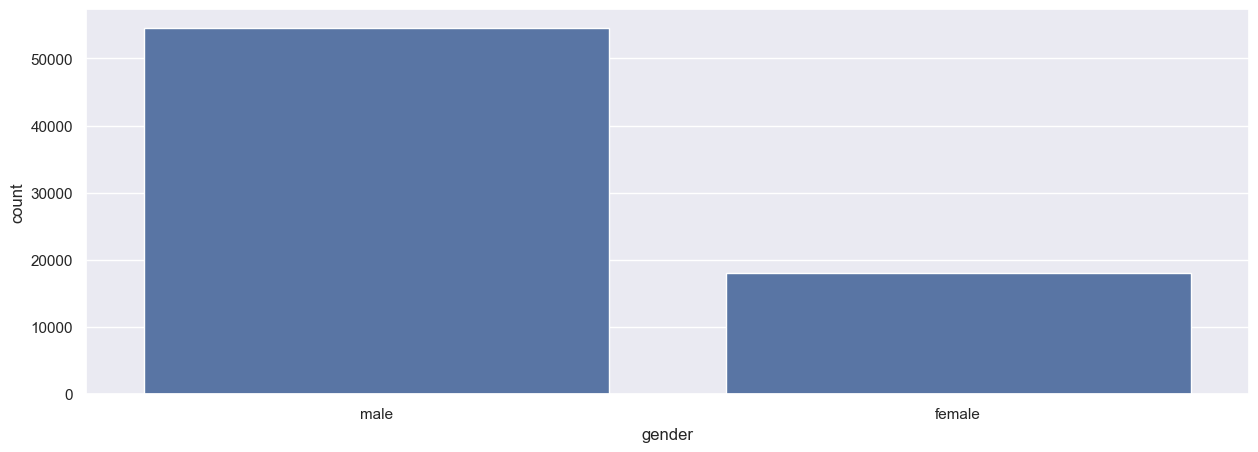

In [ ]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="gender", 
        data=df[df['gender'].notna()], 
        order=['male','female'])

plt.show()


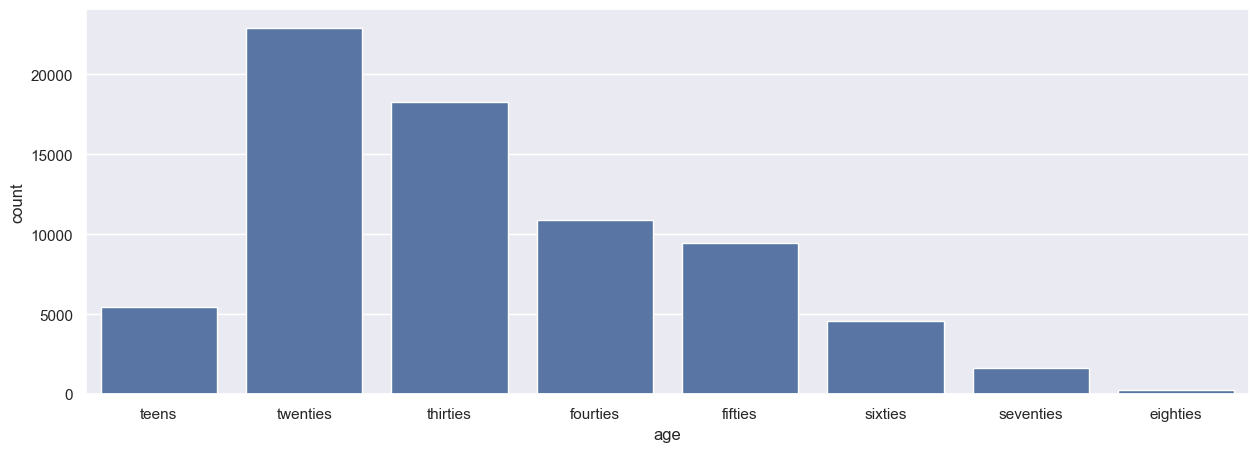

In [ ]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age", 
        data=df[df['age'].notna()], 
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()


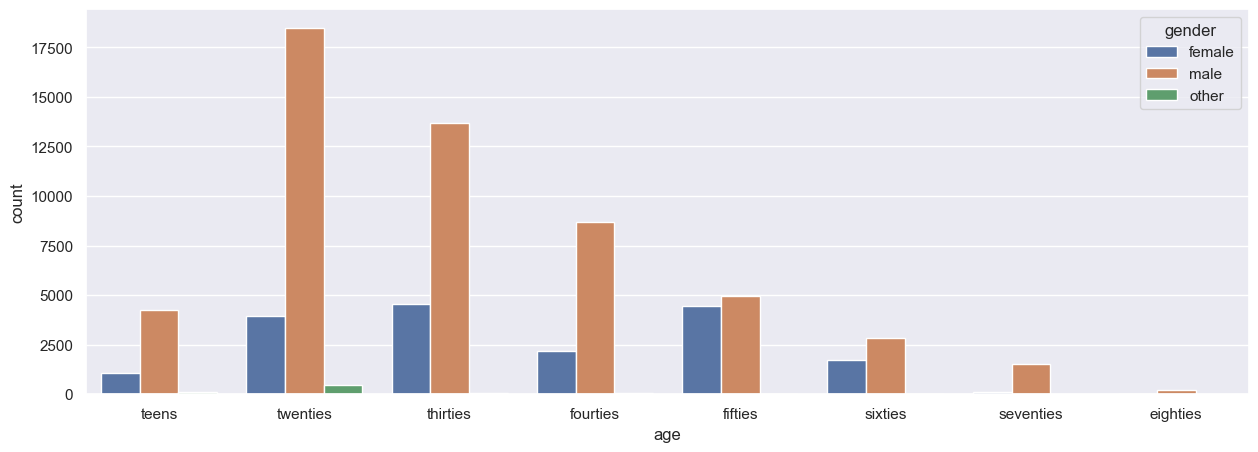

In [ ]:
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

initial: (73466, 4) final: (73466, 4)


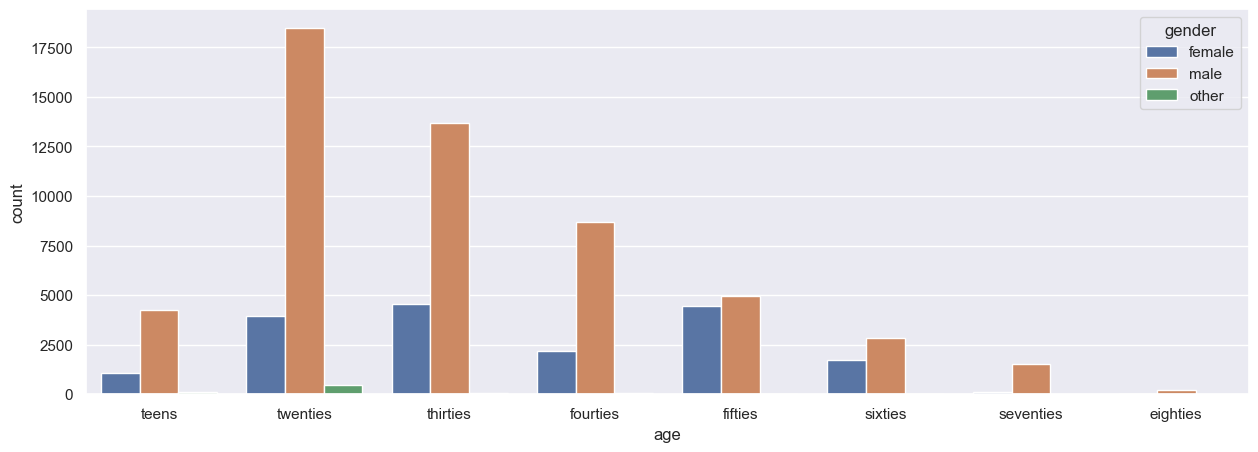

In [ ]:
start=df.shape
#df.isna().sum()
end = df[df['age'].notna()& df['gender'].notna()].shape
print("initial: {} final: {}".format(start, end))
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()& df['gender'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

DATA PREPROCESSING

In [2]:
#we extract the columns that we think useful are
df = df[['filename','age','gender']]
#To clean the data we remove the sample with NaN attribute values.
data = df[df['age'].notna() & df['gender'].notna()]
data.reset_index(inplace=True, drop=True)
data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female
3,cv-valid-train/sample-000014.mp3,sixties,male
4,cv-valid-train/sample-000019.mp3,fifties,male


In [3]:
#data['gender'] = pd.to_numeric(data['gender'],errors = 'coerce')
#data.dtypes
#if the below code fail to covert gender datatype and values then uncomment above code
cleanup_nums = {"gender": {"male":1,"female":0,"other":0.5}}
data = data.replace(cleanup_nums)
data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,0.0
1,cv-valid-train/sample-000008.mp3,seventies,1.0
2,cv-valid-train/sample-000013.mp3,thirties,0.0
3,cv-valid-train/sample-000014.mp3,sixties,1.0
4,cv-valid-train/sample-000019.mp3,fifties,1.0


In [8]:
import librosa
ds_path = "datasets/common_voice/cv-valid-train/"

#this function is used to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
        
features = feature_extraction(data.iloc[0]['filename'])
print("features: ", features)

features:  [np.float64(2147.605880358906), np.float64(2430.4749711923996), np.float64(4428.830553016453), np.float32(-625.28143), np.float32(111.306145), np.float32(6.3690844), np.float32(34.7671), np.float32(31.623457), np.float32(-4.721564), np.float32(-0.5119338), np.float32(-4.9454904), np.float32(-12.71285), np.float32(-2.0436711), np.float32(-3.7277248), np.float32(-10.708405), np.float32(-11.206564), np.float32(-12.003515), np.float32(-8.506438), np.float32(-5.472296), np.float32(-4.950396), np.float32(-3.7100523), np.float32(-6.3149858), np.float32(-6.3280854)]


In [10]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 72001
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.extend([row['age'], row['gender']])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age", "gender"])

df_features = create_df_features(data)
df_features

72000/73465

,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age,gender
0,2147.605880,2430.474971,4428.830553,-625.281433,111.306145,6.369084,34.767101,31.623457,-4.721564,-0.511934,...,-11.206564,-12.003515,-8.506438,-5.472296,-4.950396,-3.710052,-6.314986,-6.328085,twenties,0.0
1,2815.325440,2451.922347,4884.633819,-469.936646,126.283386,-16.548649,3.546792,2.184188,13.748076,-1.324955,...,1.132519,6.090082,-1.732454,-1.226424,-6.432128,-7.269326,-4.796601,-3.129156,seventies,1.0
2,1844.637736,1491.011525,3164.948048,-418.205475,147.666870,-49.974003,-2.286364,37.185310,-8.906048,-14.228477,...,-9.928527,-7.873624,-5.476490,-2.298846,-6.556987,-5.206552,-0.403855,-3.877070,thirties,0.0
3,2123.711334,2202.012929,4111.215965,-464.910706,118.437225,19.749662,27.143229,26.438824,2.309232,-9.353925,...,-2.908412,-4.496074,-2.716447,-0.080573,-5.294940,-5.868721,0.600507,-3.375832,sixties,1.0
4,2360.672043,2957.220239,4767.080050,-343.833008,157.153885,7.661150,41.898964,-15.152472,28.925106,0.091127,...,6.319802,-1.603871,3.837120,-2.643298,2.323319,-1.382684,3.791498,-3.534383,fifties,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71996,1828.354859,2692.446846,4293.097527,-415.210388,150.393692,28.397150,-6.448151,13.693564,16.949726,2.420437,...,-13.714085,-16.492376,-7.600893,2.335110,4.556519,3.730406,2.279242,-2.679997,twenties,1.0
71997,2671.263945,1807.279732,4299.418605,-312.204407,125.228539,-54.545887,13.264955,6.392467,-25.304705,19.149147,...,2.886986,-11.988918,-3.275069,1.839600,-8.619382,1.252333,-2.084241,-5.998644,thirties,0.0
71998,2289.917009,1925.874889,4020.540149,-434.903809,69.681198,-7.500330,17.323591,12.228147,-8.517142,-5.947699,...,-5.004448,-13.084766,-2.537116,-3.140797,-6.377846,0.810811,-6.571216,-6.878583,fifties,0.0
71999,2392.417793,2254.624318,4445.791165,-498.258759,117.243164,3.354279,7.896785,4.512192,-1.632573,-19.218840,...,-3.571636,-1.528203,-7.226726,-1.952783,-2.660048,-5.946280,-8.115157,-9.211823,twenties,0.0


In [ ]:
df_features.to_csv("df_features.csv", index=False)
print("✅ DataFrame saved as df_features.csv")

In [4]:
df_features = pd.read_csv("df_features.csv") 
df_features.head()


,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age,gender
0,2147.605880,2430.474971,4428.830553,-625.28143,111.306145,6.369084,34.767100,31.623457,-4.721564,-0.511934,...,-11.206564,-12.003515,-8.506438,-5.472296,-4.950396,-3.710052,-6.314986,-6.328085,twenties,0.0
1,2815.325440,2451.922347,4884.633819,-469.93665,126.283390,-16.548649,3.546792,2.184188,13.748076,-1.324955,...,1.132519,6.090082,-1.732454,-1.226424,-6.432128,-7.269326,-4.796601,-3.129156,seventies,1.0
2,1844.637736,1491.011525,3164.948048,-418.20547,147.666870,-49.974003,-2.286364,37.185310,-8.906048,-14.228477,...,-9.928527,-7.873624,-5.476490,-2.298846,-6.556987,-5.206552,-0.403855,-3.877070,thirties,0.0
3,2123.711334,2202.012929,4111.215965,-464.91070,118.437225,19.749662,27.143229,26.438824,2.309232,-9.353925,...,-2.908412,-4.496074,-2.716447,-0.080573,-5.294941,-5.868722,0.600507,-3.375832,sixties,1.0
4,2360.672043,2957.220239,4767.080050,-343.83300,157.153880,7.661149,41.898964,-15.152473,28.925106,0.091127,...,6.319802,-1.603871,3.837120,-2.643298,2.323319,-1.382684,3.791498,-3.534383,fifties,1.0


In [5]:
from sklearn.preprocessing import StandardScaler

def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 0:-2], dtype = float))
    # with data.iloc[:, 0:-1] we don't consider the label column
        
    return scaled_data, scaler

x, scaler = scale_features(df_features)

In [13]:
print("Before scaling:", df_features.iloc[0].values[:-1])
print("\nAfter scaling:", x[0])

Before scaling: [np.float64(2147.605880358906) np.float64(2430.4749711924)
 np.float64(4428.830553016453) np.float64(-625.28143)
 np.float64(111.306145) np.float64(6.3690844) np.float64(34.7671)
 np.float64(31.623457) np.float64(-4.721564) np.float64(-0.5119338)
 np.float64(-4.9454904) np.float64(-12.71285) np.float64(-2.0436711)
 np.float64(-3.7277248) np.float64(-10.708405) np.float64(-11.206564)
 np.float64(-12.003515) np.float64(-8.506438) np.float64(-5.472296)
 np.float64(-4.950396) np.float64(-3.7100523) np.float64(-6.3149858)
 np.float64(-6.3280854) 'twenties']

After scaling: [-0.67802953 -0.13459492 -0.4088571  -1.99833197 -0.21403089  0.48965988
  0.76893139  1.67497654 -0.87039751  0.16526177 -0.27984952 -1.0940377
  0.46460623 -0.01610891 -1.19120471 -1.70995587 -1.3347915  -1.19209126
 -0.56716445 -0.36635233 -0.50654646 -1.03617407 -0.64745647]


In [14]:
df_features['age'].unique()


array(['twenties', 'seventies', 'thirties', 'sixties', 'fifties',
       'fourties', 'teens', 'eighties'], dtype=object)

In [15]:
df_features['gender'].unique()


array([0. , 1. , 0.5])

In [8]:
from sklearn.preprocessing import LabelEncoder

def get_labels(data):
    age_labels = data["age"]
    gender_labels = data["gender"]
    
    # Create separate encoders for each target
    age_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()
    
    age_labels = age_encoder.fit_transform(age_labels)
    gender_labels = gender_encoder.fit_transform(gender_labels)
    
    return age_labels, gender_labels, age_encoder, gender_encoder


# Apply
y_age, y_gender, encoder_age, encoder_gender = get_labels(df_features)

print("Age Before encoding:", df_features.iloc[0]['age'])
print("After encoding (Age):", y_age[0])
print("Age Classes:", encoder_age.classes_)

print("\nGender Before encoding:", df_features.iloc[0]['gender'])
print("After encoding (Gender):", y_gender[0])
print("Gender Classes:", encoder_gender.classes_)


Age Before encoding: twenties
After encoding (Age): 7
Age Classes: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']

Gender Before encoding: 0.0
After encoding (Gender): 0
Gender Classes: [0.  0.5 1. ]


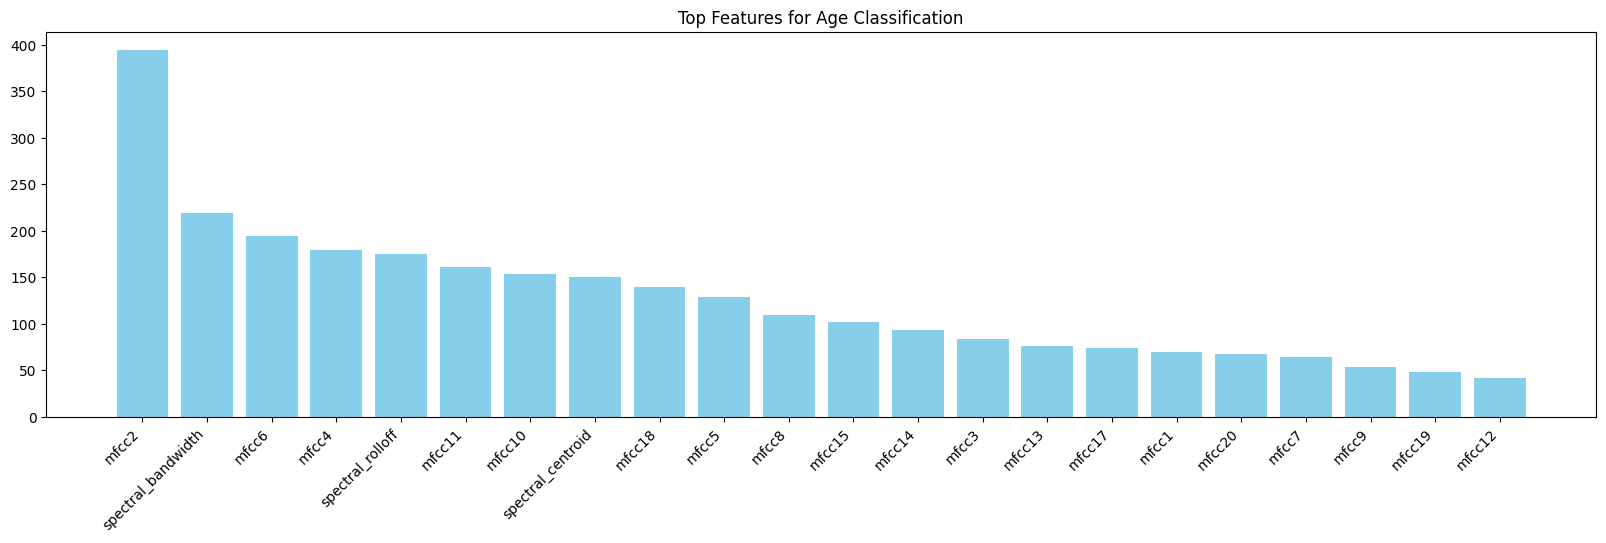

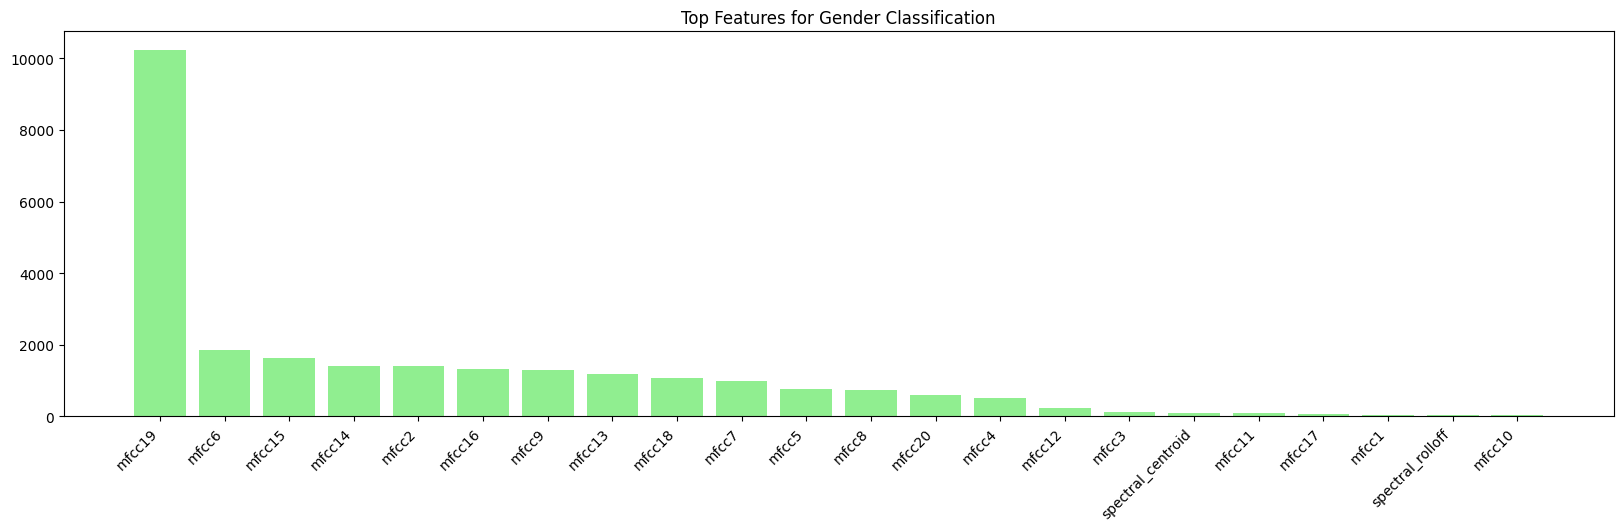

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np

n_features = 22

feature_names = df_features.columns[:-1]  # exclude label column if it's the last one

# ---- Age Feature Selection ----
f_selector_age = SelectKBest(f_classif, k=n_features).fit(x, y_age)
scores_age = f_selector_age.scores_
indices_age = np.argsort(scores_age)[::-1]

top_features_age = [feature_names[i] for i in indices_age[:n_features]]

plt.figure(figsize=(20, 5))
plt.bar(top_features_age, scores_age[indices_age[:n_features]], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top Features for Age Classification")
plt.show()

# ---- Gender Feature Selection ----
f_selector_gender = SelectKBest(f_classif, k=n_features).fit(x, y_gender)
scores_gender = f_selector_gender.scores_
indices_gender = np.argsort(scores_gender)[::-1]

top_features_gender = [feature_names[i] for i in indices_gender[:n_features]]

plt.figure(figsize=(20, 5))
plt.bar(top_features_gender, scores_gender[indices_gender[:n_features]], color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.title("Top Features for Gender Classification")
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# One-hot encode age classes (multi-class)
y_age_cat = to_categorical(y_age)

# Gender is binary (0/1) — no need for one-hot unless you want to use softmax(2)
y_gender_cat = to_categorical(y_gender)

# Split into train and test
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    x, y_age_cat, y_gender_cat, test_size=0.2, random_state=42, stratify=y_age
)
X_train, X_val, y_age_train, y_age_val, y_gender_train, y_gender_val = train_test_split(
    X_train, y_age_train, y_gender_train, test_size=0.2, random_state=42, stratify=y_age_train.argmax(axis=1)
)

print("Training set size:", X_train.shape) 
print("Training labels shape (age):", y_age_train.shape)
print("Training labels shape (gender):", y_gender_train.shape)
print("Test set size:", X_test.shape)  
print("Test labels shape (age):", y_age_test.shape)
print("Training labels shape (gender):", y_gender_test.shape)

print("\nTrain set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (46080, 23)
Training labels shape (age): (46080, 8)
Training labels shape (gender): (46080, 3)
Test set size: (14401, 23)
Test labels shape (age): (14401, 8)
Training labels shape (gender): (14401, 3)

Train set size: (46080, 23)
Validation set size: (11520, 23)
Test set size: (14401, 23)


In [14]:
X_train[0]

array([ 1.4912043 ,  1.21607888,  1.52754261,  1.00173821, -0.69231263,
       -0.80538088,  1.3568382 , -1.6831418 ,  1.94052071,  0.40274555,
        0.55681306,  1.02507528, -0.68903814,  1.54722993, -0.09867056,
        1.51663584, -0.08684621, -0.38820041,  1.59009194, -0.08946862,
        0.48750225, -0.0910328 , -0.43235203])

In [15]:
y_age_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0.])

In [16]:
y_gender_train[0]

array([0., 0., 1.])

MODEL DEVELOPMENT

Age

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks

input_dim = X_train.shape[1]
n_age_classes = y_age_cat.shape[1]

weight_decay = 1e-4   # L2 regularization strength
dropout_rate = 0.35

# --- Functional model with residual blocks ---
def dense_res_block(x, units, wd=weight_decay, drop=dropout_rate, name=None):
    shortcut = x
    x = layers.Dense(units, activation=None,
                     kernel_regularizer=regularizers.l2(wd),
                     name=None if name is None else name + "_dense")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)            # smoother than relu for many tasks
    x = layers.Dropout(drop)(x)
    # project shortcut if dims mismatch
    if shortcut.shape[-1] != units:
        shortcut = layers.Dense(units, activation=None,
                                kernel_regularizer=regularizers.l2(wd))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("gelu")(x)
    return x

# Input
inp = layers.Input(shape=(input_dim,))

# Stem
x = layers.Dense(512, activation=None, kernel_regularizer=regularizers.l2(weight_decay))(inp)
x = layers.BatchNormalization()(x)
x = layers.Activation("gelu")(x)
x = layers.Dropout(0.4)(x)

# Residual blocks
x = dense_res_block(x, 512)
x = dense_res_block(x, 256)
x = dense_res_block(x, 256)
x = dense_res_block(x, 128)

# Head
x = layers.BatchNormalization()(x)
x = layers.Activation("gelu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("gelu")(x)
x = layers.Dropout(0.25)(x)

out = layers.Dense(n_age_classes, activation='softmax', name='age_output')(x)

age_model = models.Model(inputs=inp, outputs=out, name="age_res_mlp")

# --- Optimizer + compile ---
# Option A: AdamW (has weight decay)
try:
    opt = optimizers.experimental.AdamW(learning_rate=5e-4, weight_decay=weight_decay)
except Exception:
    # fallback to Adam if older TF
    opt = optimizers.Adam(learning_rate=5e-4)

age_model.compile(
    optimizer=opt,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # label smoothing helps generalization
    metrics=['accuracy']
)

age_model.summary()



Model: "age_res_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     12,288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_2[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 256)       │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 695,944 (2.65 MB)

 Trainable params: 691,336 (2.64 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [23]:
# --- Useful callbacks for training ---
cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
cb_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
cb_checkpoint = callbacks.ModelCheckpoint('best_age_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# --- Example train call (adjust epochs & batch_size as needed) ---
history = age_model.fit(
    X_train, y_age_train,
    validation_data=(X_val, y_age_val),   # supply a validation set
    epochs=100,
    batch_size=64,
    callbacks=[cb_early, cb_reduce, cb_checkpoint],
    class_weight=None,                    # set if classes are imbalanced, see notes below
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from None to 1.76938, saving model to best_age_model.keras
720/720 - 12s - 17ms/step - accuracy: 0.3081 - loss: 2.0438 - val_accuracy: 0.4269 - val_loss: 1.7694 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 1.76938 to 1.63559, saving model to best_age_model.keras
720/720 - 8s - 12ms/step - accuracy: 0.3855 - loss: 1.8402 - val_accuracy: 0.4892 - val_loss: 1.6356 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 1.63559 to 1.52207, saving model to best_age_model.keras
720/720 - 7s - 10ms/step - accuracy: 0.4384 - loss: 1.7362 - val_accuracy: 0.5460 - val_loss: 1.5221 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 1.52207 to 1.43037, saving model to best_age_model.keras
720/720 - 7s - 10ms/step - accuracy: 0.4808 - loss: 1.6463 - val_accuracy: 0.5803 - val_loss: 1.4304 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 1.43037 to 1.36000, saving model 

In [24]:
test_loss, test_acc = age_model.evaluate(X_test, y_age_test)
print(f"\n🎯 Test Accuracy: {test_acc * 100:.2f}%")


451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8935 - loss: 0.6785

🎯 Test Accuracy: 89.35%


In [25]:
# Evaluate
results = age_model.evaluate(X_test, y_age_test)
print(f"\n🧓 Age Test Loss: {results[0]*100:.2f}%")
print(f"🧓 Age Test Accuracy: {results[1]*100:.2f}%")

# Predictions
y_pred_age = age_model.predict(X_test)

# Convert back to class labels
y_pred_age_classes = np.argmax(y_pred_age, axis=1)
y_true_age_classes = np.argmax(y_age_test, axis=1)


451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.6785

🧓 Age Test Loss: 67.85%
🧓 Age Test Accuracy: 89.35%
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


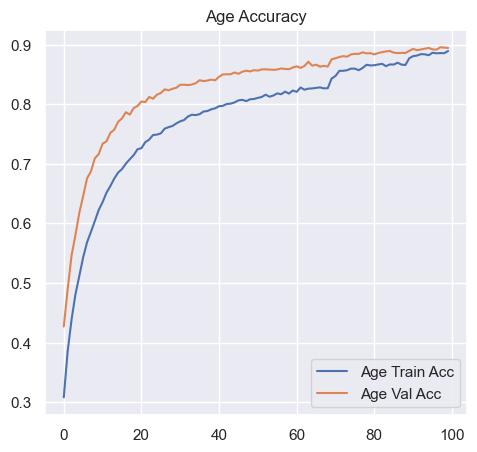

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Age Train Acc')
plt.plot(history.history['val_accuracy'], label='Age Val Acc')
plt.legend()
plt.title('Age Accuracy')

plt.show()


              precision    recall  f1-score   support

           0       0.96      0.91      0.93        47
           1       0.92      0.93      0.92      1850
           2       0.91      0.87      0.89      2140
           3       0.89      0.95      0.92       319
           4       0.94      0.93      0.93       897
           5       0.92      0.83      0.87      1067
           6       0.86      0.90      0.88      3592
           7       0.89      0.89      0.89      4489

    accuracy                           0.89     14401
   macro avg       0.91      0.90      0.91     14401
weighted avg       0.89      0.89      0.89     14401



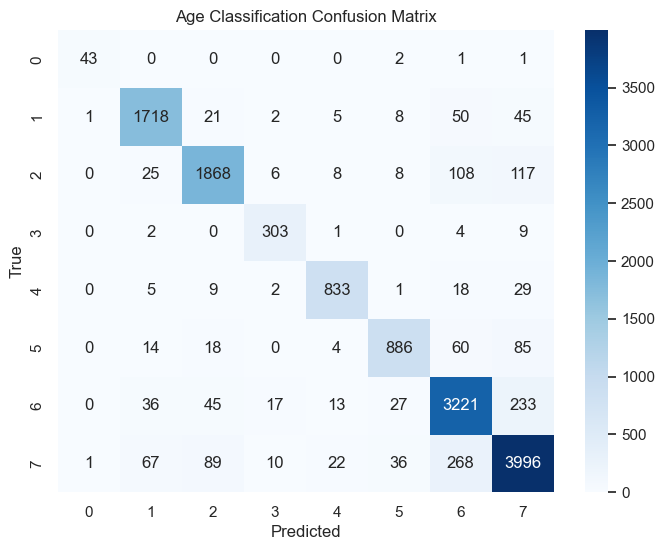

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Detailed metrics
print(classification_report(y_true_age_classes, y_pred_age_classes))

# Confusion matrix
cm = confusion_matrix(y_true_age_classes, y_pred_age_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Age Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [28]:
age_model.save("age_from_voice 89.keras")


Gender

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Input and output dimensions
input_dim = X_train.shape[1]
n_gender_classes = y_gender_cat.shape[1]

# --- Model Architecture ---
gender_model = models.Sequential([
    layers.Input(shape=(input_dim,)),

    # Shared hidden layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Output layer (Age classification)
    layers.Dense(n_gender_classes, activation='softmax')
])

# --- Compile the model ---
gender_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Summary ---
gender_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,963 (160.01 KB)

 Trainable params: 40,195 (157.01 KB)

 Non-trainable params: 768 (3.00 KB)

In [31]:
history = gender_model.fit(
    X_train, y_gender_train,
    validation_data=(X_val, y_gender_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8951 - loss: 0.2647 - val_accuracy: 0.9181 - val_loss: 0.2143
Epoch 2/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.2610 - val_accuracy: 0.9198 - val_loss: 0.2066
Epoch 3/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8996 - loss: 0.2545 - val_accuracy: 0.9227 - val_loss: 0.2050
Epoch 4/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.2487 - val_accuracy: 0.9201 - val_loss: 0.2053
Epoch 5/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9024 - loss: 0.2469 - val_accuracy: 0.9239 - val_loss: 0.1992
Epoch 6/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9044 - loss: 0.2451 - val_accuracy: 0.9247 - val_loss: 0.1960
Epoch 7/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9041 - loss: 0.2400 - val_accuracy: 0.9255 - val_loss: 0.1918
Epoch 8/50
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9048 - loss: 0.2388 - 

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks

input_dim = X_train.shape[1]
n_gender_classes = y_gender_cat.shape[1]

weight_decay = 1e-4   # L2 regularization strength
dropout_rate = 0.35

# --- Functional model with residual blocks ---
def dense_res_block(x, units, wd=weight_decay, drop=dropout_rate, name=None):
    shortcut = x
    x = layers.Dense(units, activation=None,
                     kernel_regularizer=regularizers.l2(wd),
                     name=None if name is None else name + "_dense")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)            # smoother than relu for many tasks
    x = layers.Dropout(drop)(x)
    # project shortcut if dims mismatch
    if shortcut.shape[-1] != units:
        shortcut = layers.Dense(units, activation=None,
                                kernel_regularizer=regularizers.l2(wd))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("gelu")(x)
    return x

# Input
inp = layers.Input(shape=(input_dim,))

# Stem
x = layers.Dense(512, activation=None, kernel_regularizer=regularizers.l2(weight_decay))(inp)
x = layers.BatchNormalization()(x)
x = layers.Activation("gelu")(x)
x = layers.Dropout(0.4)(x)

# Residual blocks
x = dense_res_block(x, 512)
x = dense_res_block(x, 256)
x = dense_res_block(x, 256)
x = dense_res_block(x, 128)

# Head
x = layers.BatchNormalization()(x)
x = layers.Activation("gelu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(weight_decay))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("gelu")(x)
x = layers.Dropout(0.25)(x)

out = layers.Dense(n_gender_classes, activation='softmax', name='gender_output')(x)

gender_model = models.Model(inputs=inp, outputs=out, name="gender_res_mlp")

# --- Optimizer + compile ---
# Option A: AdamW (has weight decay)
try:
    opt = optimizers.experimental.AdamW(learning_rate=5e-4, weight_decay=weight_decay)
except Exception:
    # fallback to Adam if older TF
    opt = optimizers.Adam(learning_rate=5e-4)

gender_model.compile(
    optimizer=opt,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # label smoothing helps generalization
    metrics=['accuracy']
)

gender_model.summary()



Model: "gender_res_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 512)       │     12,288 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 512)       │          0 │ activation_22[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │    262,656 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 512)       │          0 │ activation_23[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 512)       │          0 │ dropout_17[0][0], │
│                     │                   │            │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 512)       │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    131,328 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │    131,328 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256)       │          0 │ activation_25[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 256)       │          0 │ dropout_18[0][0], │
│                     │                   │            │ batch_normalizat

 Total params: 695,299 (2.65 MB)

 Trainable params: 690,691 (2.63 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [44]:
# --- Useful callbacks for training ---
cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
cb_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
cb_checkpoint = callbacks.ModelCheckpoint('best_gender_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# --- Example train call (adjust epochs & batch_size as needed) ---
history = gender_model.fit(
    X_train, y_gender_train,
    validation_data=(X_val, y_gender_val),   # supply a validation set
    epochs=100,
    batch_size=64,
    callbacks=[cb_early, cb_reduce, cb_checkpoint],
    class_weight=None,                    # set if classes are imbalanced, see notes below
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from None to 0.53258, saving model to best_gender_model.keras
720/720 - 8s - 11ms/step - accuracy: 0.8788 - loss: 0.5916 - val_accuracy: 0.9041 - val_loss: 0.5326 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.53258 to 0.50988, saving model to best_gender_model.keras
720/720 - 9s - 12ms/step - accuracy: 0.8842 - loss: 0.5618 - val_accuracy: 0.9063 - val_loss: 0.5099 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.50988 to 0.47910, saving model to best_gender_model.keras
720/720 - 8s - 11ms/step - accuracy: 0.8918 - loss: 0.5305 - val_accuracy: 0.9134 - val_loss: 0.4791 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.47910 to 0.45539, saving model to best_gender_model.keras
720/720 - 7s - 10ms/step - accuracy: 0.8942 - loss: 0.5094 - val_accuracy: 0.9200 - val_loss: 0.4554 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 0.45539 to 0.43837, sa

In [45]:
test_loss, test_acc = gender_model.evaluate(X_test, y_gender_test)
print(f"\n🎯 Test Accuracy: {test_acc * 100:.2f}%")


451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9662 - loss: 0.2844

🎯 Test Accuracy: 96.62%


In [50]:
# Evaluate
results = gender_model.evaluate(X_test, y_gender_test)
print(f"\n🚻 Gender Test Loss: {results[0]*100:.2f}%")
print(f"🚻 Gender Test Accuracy: {results[1]*100:.2f}%")

# Predictions
y_pred_gender = gender_model.predict(X_test)

# Convert back to class labels
y_pred_gender_classes = np.argmax(y_pred_gender, axis=1)
y_true_gender_classes = np.argmax(y_gender_test, axis=1)


451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9662 - loss: 0.2844

🚻 Gender Test Loss: 28.44%
🚻 Gender Test Accuracy: 96.62%
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


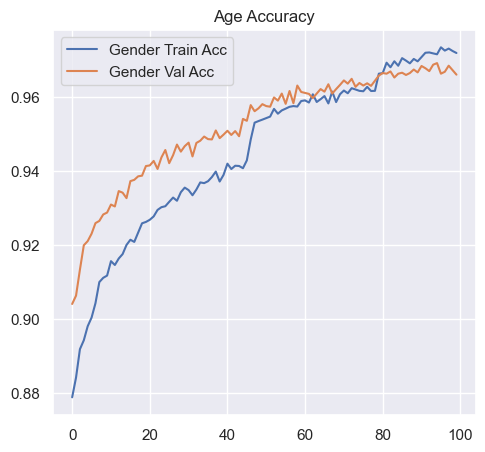

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Gender Train Acc')
plt.plot(history.history['val_accuracy'], label='Gender Val Acc')
plt.legend()
plt.title('Age Accuracy')

plt.show()



🚻 Gender Classification Report:

              precision    recall  f1-score   support

      Female       0.94      0.92      0.93      3508
       Other       0.95      0.87      0.91       161
        Male       0.97      0.98      0.98     10732

    accuracy                           0.97     14401
   macro avg       0.95      0.93      0.94     14401
weighted avg       0.97      0.97      0.97     14401



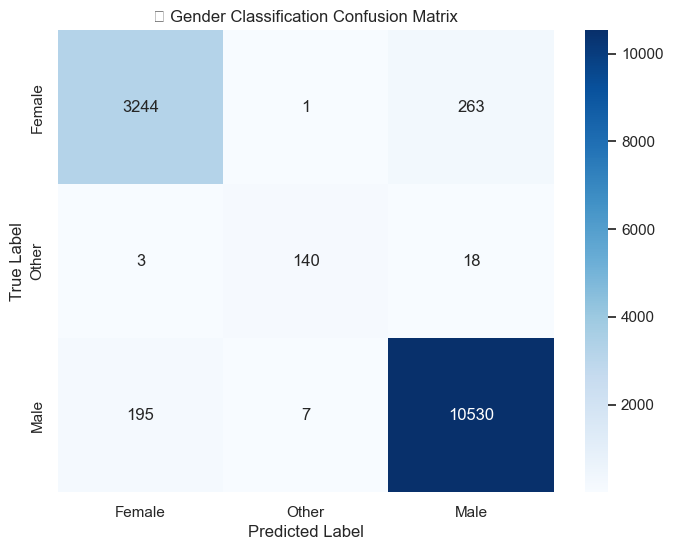

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# Detailed metrics
print("\n🚻 Gender Classification Report:\n")
print(classification_report(y_true_gender_classes, y_pred_gender_classes, target_names=['Female', 'Other', 'Male']))

# Confusion matrix
cm = confusion_matrix(y_true_gender_classes, y_pred_gender_classes)

# Define readable labels
labels = ['Female', 'Other', 'Male']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("🚻 Gender Classification Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [49]:
gender_model.save("gender_from_voice 96.keras")


RANDOM PREDICTIONS

In [1]:
import librosa
import numpy as np

def feature_extraction(filepath, sampling_rate=48000):
    features = []
    audio, _ = librosa.load(filepath, sr=sampling_rate)

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features += [spectral_centroid, spectral_bandwidth, spectral_rolloff]

    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    features += [np.mean(m) for m in mfcc]

    return np.array(features).reshape(1, -1)



In [19]:
import os
import random
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# === Load Models ===
age_model = load_model("models/age_from_voice 89.keras")
gender_model = load_model("models/gender_from_voice 96.keras")

print("✅ Models loaded successfully!")

# === Paths ===
test_dir = "datasets/common_voice/cv-valid-test/cv-valid-test/"

# === Pick a Random File from Test Directory ===
def pick_random_file(directory):
    files = [f for f in os.listdir(directory) if f.endswith(('.wav', '.mp3', '.flac'))]
    if not files:
        raise FileNotFoundError(f"No audio files found in {directory}")
    return os.path.join(directory, random.choice(files))

# === Run Test ===
def test_random_audio(age_model, gender_model, scaler, encoder_age, encoder_gender):
    random_file = pick_random_file(test_dir)
    print(f"\n🎧 Randomly Selected File: {random_file}")

    features = feature_extraction(random_file)
    features_scaled = scaler.transform(features)

    # Predict
    pred_age = age_model.predict(features_scaled, verbose=0)
    pred_gender = gender_model.predict(features_scaled, verbose=0)

    # Decode predictions
    pred_age_label = encoder_age.inverse_transform([np.argmax(pred_age)])
    pred_gender_label = encoder_gender.inverse_transform([np.argmax(pred_gender)])

    # Convert numeric gender → readable text
    gender_map = {0: "Female", 0.5: "Other", 1: "Male"}
    gender_readable = gender_map.get(float(pred_gender_label[0]), "Unknown")

    print(f"🎯 Predicted → Age Group: {pred_age_label[0]}")
    print(f"🎯 Predicted → Gender: {gender_readable}")

    return random_file

# === Run ===
file_path = test_random_audio(age_model, gender_model, scaler, encoder_age, encoder_gender)

# === (Optional) Play the Audio ===
import IPython.display as ipd
ipd.Audio(file_path)


✅ Models loaded successfully!

🎧 Randomly Selected File: datasets/common_voice/cv-valid-test/cv-valid-test/sample-002193.mp3
🎯 Predicted → Age Group: thirties
🎯 Predicted → Gender: Male


In [11]:
from joblib import dump

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# After training your models
dump(scaler, "scaler.pkl")

['scaler.pkl']

END